# Predicting if a Patient Has Heart Disease

In [1]:
#Import the required libraries
install.packages("kknn")
install.packages("gridExtra")
library(tidyverse)
library(repr)
library(tidymodels)
library(gridExtra)   
library(patchwork)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.2”
Warning message:
“package ‘readr’ was built under R version 4.1.2”
Warning message:
“package ‘dplyr’ was built under R version 4.1.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.1.3”
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ r

## Introduction

Coronary heart disease is characterized by the occlusion of coronary arteries, leading to myocardial infarction, sudden cardiac arrest, congestive heart failure and ultimately death. It is considered to be one of the leading causes of mortality worldwide. Despite its fatal consequences, heart diseases can often be controlled and prevented if the person spots heart disease early and adopts a healthier lifestyle and proper treatment plans. Therefore, it is important to have resources available for the public to check whether they have heart disease or not, and take action accordingly. 

As a group, we decided that age, resting blood pressure and maximum heart rate are important factors to consider when predicting heart diseases. Maximum heart rate reflects a person’s ability to consume oxygen, with several studies showing that a higher maximum heart rate is often associated with a lower exposure to heart disease. Resting blood pressure serves a similar purpose in prediction, as a lower resting blood pressure is also related with lower risks of heart disease. Additionally, increasing age is generally associated with declining physical health and increasing risks of heart disease. We would like to know whether it’s possible to predict if a person has heart disease using age, resting blood pressure and maximum heart rate as predictors, and how accurate our predictions are.

We will be using the processed Cleveland dataset from the heart disease database provided by the UCI Machine Learning Repository to build our predicting model and test the accuracy of the prediction. 

## Code

### Loading and Tidying the Dataset

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
colmns_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restceg", "max_heart_rate",
               "exang", "oldpeak", "slope", "ca", "thal", "heart_disease")


heart_data <- read_csv(url, col_names = colmns_names)|>
    #Change the data type in the columns to the necessary data type for our classification
    mutate(across(c(trestbps, fbs, restceg, max_heart_rate, exang, oldpeak, slope, ca, thal),
                as.numeric),
          heart_disease = ifelse(heart_disease == "1" | heart_disease == "2" | 
                                 heart_disease == "3" | heart_disease == "4", "True", heart_disease),
          heart_disease = ifelse(heart_disease == "0", "False", heart_disease),
          heart_disease = as.factor(heart_disease))
# Preview the first 10 observations
head(heart_data, n=10)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restceg, max_heart_rate, exang,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,sex,cp,trestbps,chol,fbs,restceg,max_heart_rate,exang,oldpeak,slope,ca,thal,heart_disease
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,False
67,1,4,160,286,0,2,108,1,1.5,2,3,3,True
67,1,4,120,229,0,2,129,1,2.6,2,2,7,True
37,1,3,130,250,0,0,187,0,3.5,3,0,3,False
41,0,2,130,204,0,2,172,0,1.4,1,0,3,False
56,1,2,120,236,0,0,178,0,0.8,1,0,3,False
62,0,4,140,268,0,2,160,0,3.6,3,2,3,True
57,0,4,120,354,0,0,163,1,0.6,1,0,3,False
63,1,4,130,254,0,2,147,0,1.4,2,1,7,True


Table 1. Full table of values from the Processed Cleveland Heart Disease dataset.

In order to predict if there exists a heart disease in a person, we will use the three parameters mentioned above: age, blood pressure, and maximum heart rate. We believe that a good idea to begin to see how these different parameters are related to others, is to plot them against each other. So we created three different graphs to showcase this.

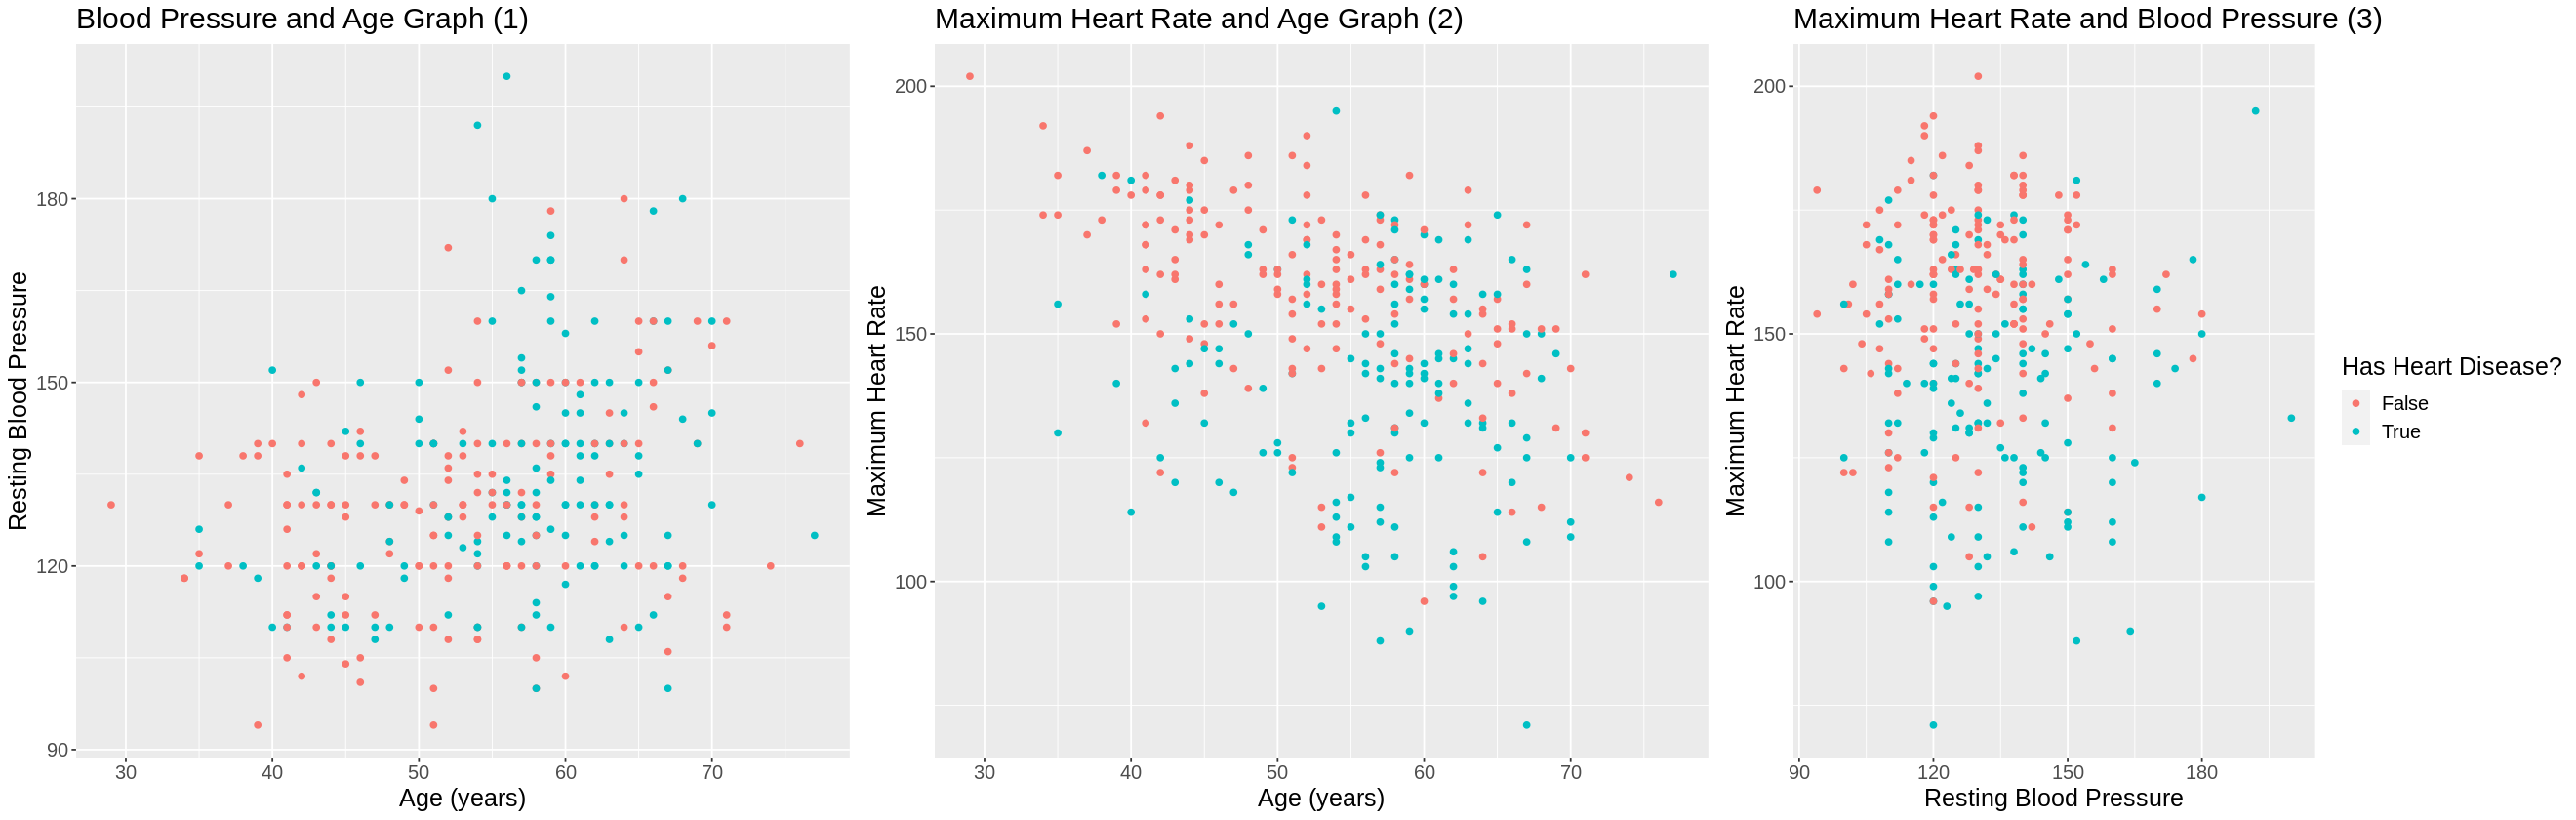

In [3]:
options(repr.plot.width=22, repr.plot.height=7)


age_trestbps_plot <- heart_data |>
    ggplot(aes(x = age, y = trestbps)) +
        geom_point(aes(color = heart_disease), show.legend = FALSE) +
        labs (x = "Age (years)", y = "Resting Blood Pressure", color = "Heart Disease?",  
              title = "Blood Pressure and Age Graph (1)")+
        theme(text = element_text(size=15))

age_max_heart_rate_plot <- heart_data |>
    ggplot(aes(x = age, y = max_heart_rate)) +
        geom_point(aes(color = heart_disease), show.legend = FALSE) +
        labs (x = "Age (years)", y = "Maximum Heart Rate",color = "Heart Disease?", title = 
              "Maximum Heart Rate and Age Graph (2)")+
        theme(text = element_text(size=15))

trestbps_max_heart_rate_plot <- heart_data |>
    ggplot(aes(x = trestbps, y = max_heart_rate)) +
        geom_point(aes(color = heart_disease)) +
        labs (x = "Resting Blood Pressure", y = "Maximum Heart Rate", color = "Has Heart Disease?",
              title = "Maximum Heart Rate and Blood Pressure (3)")+
        theme(text = element_text(size=15))

grid.arrange(age_trestbps_plot, age_max_heart_rate_plot, trestbps_max_heart_rate_plot, ncol = 3)


From left to right

Figure 1. A scatterplot to visualize the distribution, plotting age and resting blood pressure.

Figure 2. A scatterplot to visualize the distribution, plotting age and maximum heart rate.

Figure 3. A scatterplot to visualize the distribution, plotting resting blood pressure and maximum heart rate.

We already might be able to find some pattern between these variables but to better make predictions we will use a knn classification algorithm. In order to do that, the first step towards creating this algorithm is to split the data into training and testing data sets. We also observe that the two classes are interspersed all over the plot which can result in a lower accuracy classifier. The reason for this is because whatever observation we may take the $k$ closest neighbors will have different classes which makes the work hard for the classifier to determine exactly what class the observation has. Thus, we expect that our module will have around $80$% accuracy.

Now, we will start working on the classifier. First, we split the data into a training set $75$% and a testing set $25$%.

In [5]:
set.seed(1)
#select the wanted columns
heart_data <- heart_data |>
    select(age, trestbps, max_heart_rate, heart_disease)
#split the data into training and testing sets
heart_split <- initial_split(heart_data, prop = 0.75, strata = heart_disease)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)
head(heart_train, n=6)

age,trestbps,max_heart_rate,heart_disease
<dbl>,<dbl>,<dbl>,<fct>
63,145,150,False
37,130,187,False
41,130,172,False
57,140,148,False
56,140,153,False
57,150,174,False


Table 2. First 6 observations of the training set.

### Performing Classification with $k$-nearest algorithm, k=3

* First, we try performing $knn$ classification with a random $k$ value of our choice. Let it be $3$

In [6]:
set.seed(10)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_recipe <- recipe(heart_disease ~ age + trestbps + max_heart_rate, data= heart_train)|>
    step_scale(all_predictors())|>
    step_center(all_predictors())

heart_fit <- workflow()|>
    add_recipe(heart_recipe)|>
    add_model(knn_spec)|>
    fit(data = heart_train)

heart_accuracy_3 <- predict(heart_fit, heart_test)|>
    bind_cols(heart_test)|>
    metrics(truth = heart_disease, estimate = .pred_class)
heart_accuracy_3    


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6842105
kap,binary,0.3508897


Table 3. Accuracy of our classifier with 3 nearest neighbors

With $3$ nearest neighbors, we can see that the accuracy of the classifier is $68$%. This is very low accuracy and the classifier is not reliable to perform any predictions with such low accuracy. In the next steps, we will perform $10$-folds cross-validations to get the value of $k$ with highest accuracy. We hope that will make the classifier better and reliable.

#### Now, we perform 10-fold cross-validation to get the best $k$ value possible

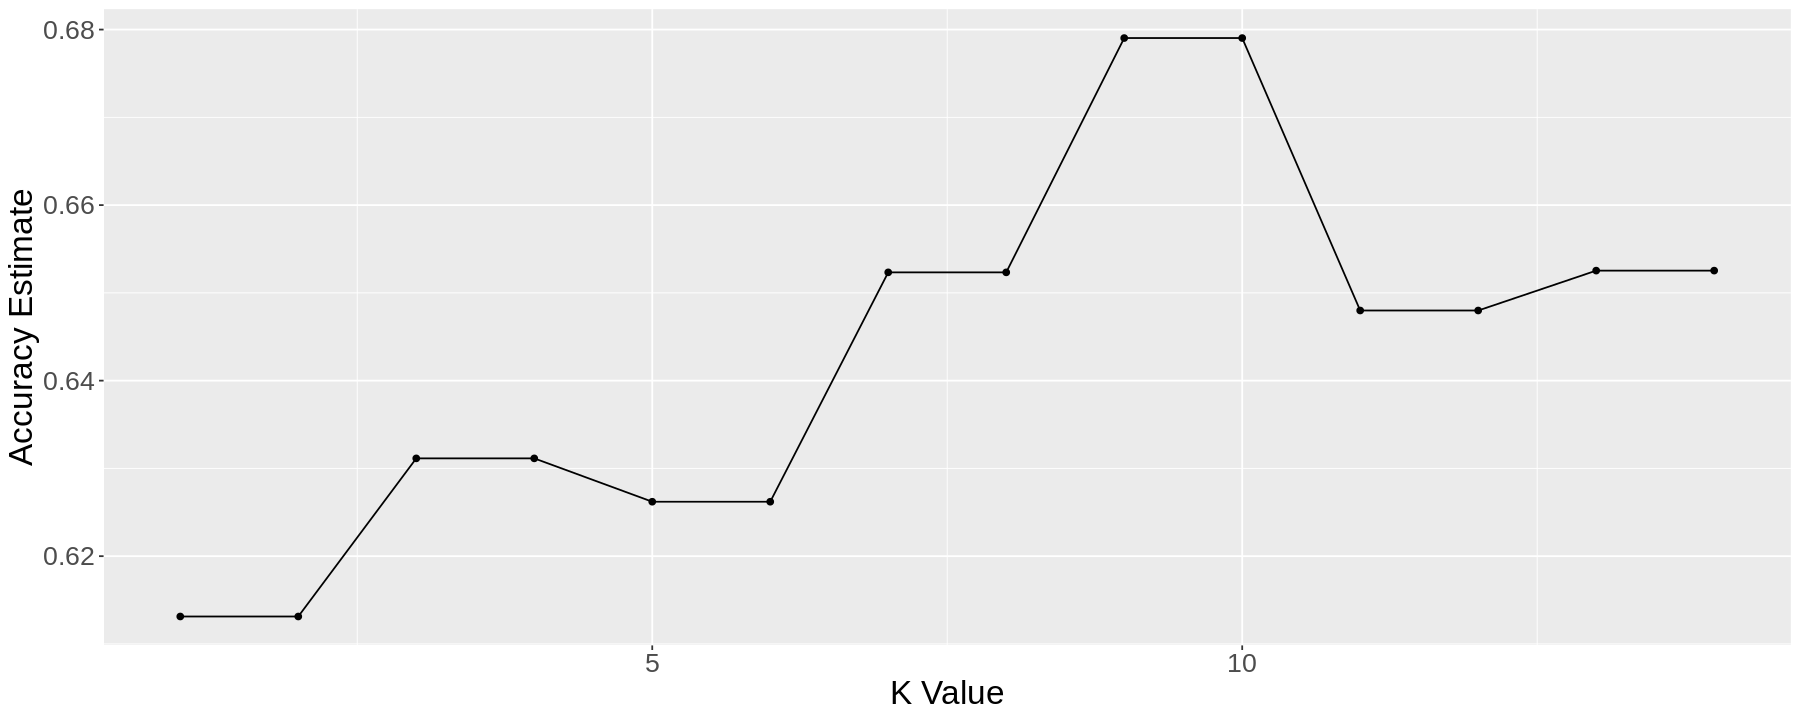

In [7]:
set.seed(100)
options(repr.plot.width=15, repr.plot.height=6)

heart_vfold <- vfold_cv(heart_train, v = 10, strata = heart_disease)
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_resamples_fit <- workflow()|>
    add_recipe(heart_recipe)|>
    add_model(knn_best_spec)|>
    tune_grid(resamples = heart_vfold, grid=20)|>
    collect_metrics()|>
    filter(.metric == "accuracy")

accuracy_v_k_plot <- heart_resamples_fit |>
    ggplot(aes(x= neighbors, y= mean))+
        geom_point()+
        geom_line()+
        labs(x= "K Value", y= "Accuracy Estimate")+
        theme(text = element_text(size=20))
accuracy_v_k_plot

Figure 4. A scatterplot to visualize the accuracy of the model using different values of k.

We observe from the graph above that the best $k$ values are $k=9$ or $k=10$. For this classifier, we will choose $k=10$. Now, we perform $k$-nearest neighbors classification with $k=10$ and we expect to get higher accuracy than with $k=3$. 

In [8]:
knn_spec_10 <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_best_fit <- workflow()|>  
    add_recipe(heart_recipe)|>
    add_model(knn_spec_10)|>
    fit(data = heart_train)

heart_best_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(10,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3348018
Best kernel: rectangular
Best k: 10

Table 4. The workflow process after applying a new model and the previous recipe, then fitting it to the training set.

In [9]:
heart_test_predections <- predict(heart_best_fit, heart_test)|>
    bind_cols(heart_test)
head(heart_test_predections, n=10)

.pred_class,age,trestbps,max_heart_rate,heart_disease
<fct>,<dbl>,<dbl>,<dbl>,<fct>
False,56,120,178,False
True,62,140,160,True
False,57,120,163,False
False,44,120,173,False
True,52,172,162,False
False,54,140,160,False
False,48,130,139,False
False,58,120,160,True
False,50,120,158,False


Table 5. Table of the first ten predictions made by the model on the testing set.

In [10]:
heart_test_accuracy <- heart_test_predections |>
    metrics(truth = heart_disease, estimate = .pred_class)
heart_test_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7236842
kap,binary,0.4356436


Table 6. The statistics of the model, relating to its quality.

In [11]:
heart_matrix <- heart_test_predections |>
    conf_mat(truth = heart_disease, estimate = .pred_class)
heart_matrix

          Truth
Prediction False True
     False    34   14
     True      7   21

Table 7. The confusion matrix of the model, which shows the number of correctly and incorrectly predicted values for both categories.

We have $55$ correctly labeled values and $21$ incorrectly labeled values. This gives the model an accuracy of about $72$%, as shown by the accuracy value in Table 6. Unfortunately, $72$% is lower than what we expected, but higher than the accuracy with $3$ nearest neighbors. As stated earlier, the reason for the low accuracy is that the observation is interspersed among the two classes we have. $72$% is the highest accuracy we can get as performing classification with different $k$ other than $9$ or $10$ will result in lower accuracy.

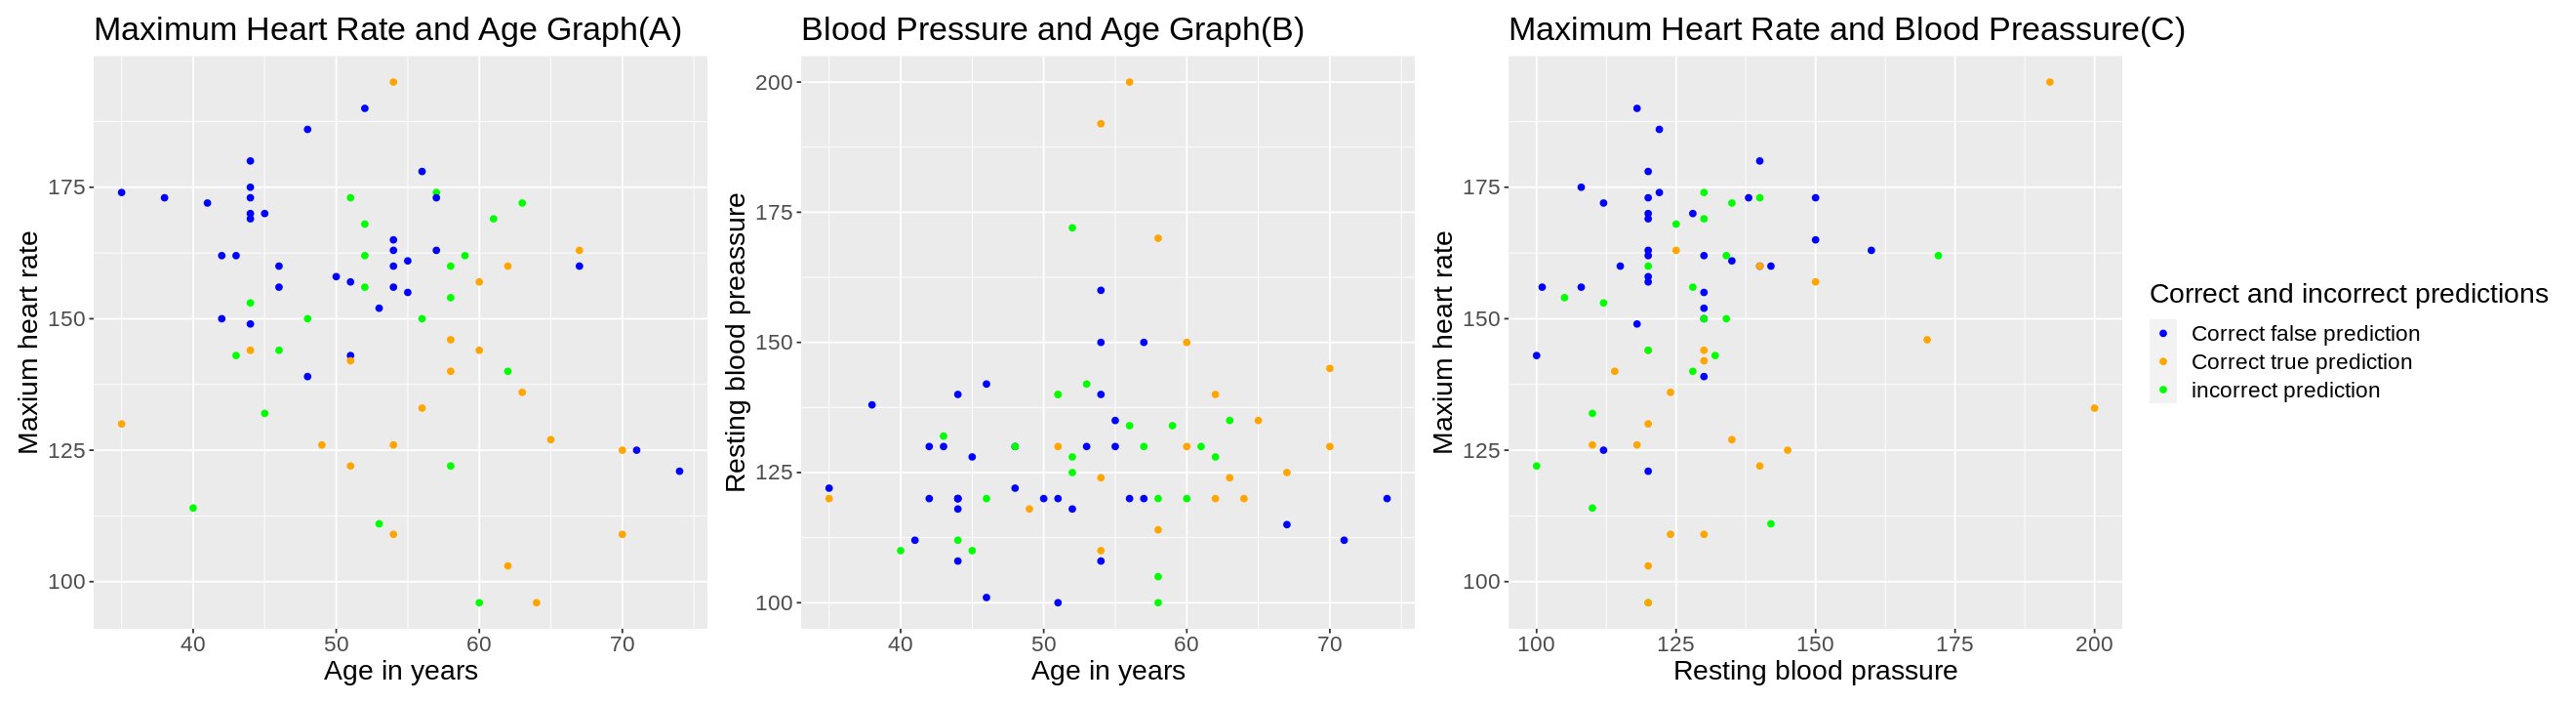

In [13]:
true_all <- heart_test_predections |>
    filter(.pred_class == "True") |>
    filter (heart_disease == "True") |>
    summarise(age,trestbps,max_heart_rate,heart_disease, .pred_class = "correct_true")


false_all <- heart_test_predections |>
    filter(.pred_class == "False") |>
    filter (heart_disease == "False") |>
    summarise(age,trestbps,max_heart_rate,heart_disease, .pred_class = "correct_false")


incorrect <- heart_test_predections |>
    filter(.pred_class == "True") |>
    filter (heart_disease == "False") |>
    summarise(age,trestbps,max_heart_rate,heart_disease, .pred_class = "incorrect")



incorrect2 <- heart_test_predections |>
    filter(.pred_class == "False") |>
    filter (heart_disease == "True") |>
    summarise(age,trestbps,max_heart_rate,heart_disease, .pred_class = "incorrect")

merged_tables <- merge(incorrect, incorrect2, by =  c("age", "trestbps", "max_heart_rate", "heart_disease",
        ".pred_class"), all.x = TRUE, all.y = TRUE)

merged_tables <- merge(merged_tables, false_all, by =  c("age", "trestbps", "max_heart_rate", "heart_disease",
        ".pred_class"), all.x = TRUE, all.y = TRUE)

merged_tables <- merge(merged_tables, true_all, by =  c("age", "trestbps", "max_heart_rate", "heart_disease",
        ".pred_class"), all.x = TRUE, all.y = TRUE)

options(repr.plot.width=22, repr.plot.height=6)

age_trestbps_plot <- merged_tables |>
    ggplot(aes(x = age, y = trestbps)) +
        geom_point(aes(color = .pred_class), show.legend = FALSE) +
        labs (x = "Age in years", y = "Resting blood preassure",  title = "Blood Pressure and Age Graph(B)")+
        theme(text = element_text(size=17)) +
        scale_color_manual(values = c("blue", "orange", "green"))

age_heart_rate_plot <- merged_tables |>
    ggplot(aes(x = age, y = max_heart_rate)) +
        geom_point(aes(color = .pred_class), show.legend = FALSE) +
        labs (x = "Age in years", y = "Maxium heart rate", title = "Maximum Heart Rate and Age Graph(A)")+
        theme(text = element_text(size=17)) +
        scale_color_manual(values = c("blue", "orange", "green"))

trestbps_heart_rate_plot <- merged_tables |>
    ggplot(aes(x = trestbps, y = max_heart_rate)) +
        geom_point(aes(color = .pred_class)) +
        labs (x = "Resting blood prassure", y = "Maxium heart rate", 
              color = "Correct and incorrect predictions", title = "Maximum Heart Rate and Blood Preassure(C)")+
        theme(text = element_text(size=17)) +
        scale_color_manual(labels = c("Correct false prediction", "Correct true prediction", "incorrect prediction"), 
                     values = c("blue", "orange", "green"))


age_heart_rate_plot + age_trestbps_plot + trestbps_heart_rate_plot + plot_layout(guides = 'collect')



Figure 5A. Maximum heart rate Vs. Age scatter plot showing correctness of predictions.\
Figure 5B. Resting Blood Pressure Vs. Age scatter plot showing correctness of predictions.\
Figure 5C. Maximum Heart Rate Vs. Resting Blood Pressure scatter plot showing correctness of predictions.

### Discussion

We found that the model predicts whether an individual has heart disease or not with an accuracy of approximately 72%. This is reasonable considering that data points that showed heart disease as existing and nonexistent were very much interspersed as seen in the plots in Figures 1-3. Moreover, heart disease is complicated because it depends on many factors other than age, resting blood pressure and maximum heart rate, and can vary from person's habits in life. Therefore, the module cannot be used for predicting heart disease for medical purposes. However, it can be used for predictions to get an overall image.

We think that classifying if someone has a heart disease or not based on data can be something very helpful. But we also need to make sure that the classifier is very accurate as we do not want to say that someone with heart disease does not have a heart disease. 
Because of this, we were expecting to have a classifier with a high accuracy and we ended up having a classifier with 73% accuracy. We believe that this level of accuracy is not bad but it is definitely not enough to be able to predict if a person has a heart disease or not. 

Originally, we hoped to build a highly accurate classifier to inform the participants about their possible health risks. However, with our model achieving only 73% accuracy in predicting heart diseases, we must be careful when promoting this to the public to avoid unnecessary panics. Yet, it is important to recognize that our goal was not to replace professions in the medical field, but to suggest participants to start monitoring their general health conditions, especially their blood pressure and heart rates, if results return positive.
We believe that despite its accuracy, the model will achieve its purpose of promoting awareness about whether one has heart disease or not. Moreover, we concluded that it might be a reasonable template to educate people on the importance of selecting good predictors, especially since we believe that there is a combination of predictors within our dataset that works very well. 

Considering the model’s successes and failures thus far, we wondered: how would changing the predictors affect the accuracy of our model? If we had used more or fewer predictors in the model, would we increase our accuracy and therefore make the model more viable in use? We had initially used a different dataset, albeit with the same variables. Could our model fit that dataset better? 
We also pondered over the utility of our model, understanding that it is not sufficient to be used in the actual medical field. This leads to the question of whether or not it is possible to adapt our model to not only fit other datasets effectively, but to also apply it to a different situation.

### References

“About Heart Disease.” Centers for Disease Control and Prevention, Centers for Disease Control and Prevention, 12 July 2022, https://www.cdc.gov/heartdisease/about.htm. 

Heart Disease Data Set. UCI Machine Learning Repository: Heart disease data set. (n.d.). Retrieved April 13, 2023, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease 

Singh, P., Singh, S., & Pandi-Jain, G. S. (2018, March 15). Effective heart disease prediction system using data mining techniques. International journal of nanomedicine. Retrieved April 13, 2023, from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5863635/ 

Timbers, T.-A., Campbell, T., & Lee, M. (2022). Data science: A first introduction. CRC Press, Taylor & Francis Group. 

What your heart rate is telling you. Harvard Health. (2020, August 30). Retrieved April 13, 2023, from https://www.health.harvard.edu/heart-health/what-your-heart-rate-is-telling-you 
